In [1]:
import pandas as pd

df_flush = pd.read_pickle('beluga_data_withflush.pkl')
df_noflush = pd.read_pickle('beluga_data_withoutflush.pkl')
df_tmpfs = pd.read_pickle('beluga-tmpfs.pkl')

In [2]:
def feature_scatter(df, zoom=False, fn="figure.pdf"):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    from matplotlib.colors import to_rgba

    df = df[df["busy_writers"] == 0]
    
    identity = None
    
    if len(df) > 0:
        identity = range(int(max(df["makespan"])) + 1)

    colours = { "afni":"#003f5c", "spm": "#bc5090", "fsl": "#ffa600" }
    markers = { "preventAD":"^", "ds001545": "X", "HCP": "o" }

    edge = "black"
    line = { 1: 1.5, 8: 0, 16: 2}
    size = { 1: 12, 8: 8*12, 16: 8*12}
    alpha = 0.5
    
    if identity is not None:
        plt.plot(identity, identity, color="black", alpha=0.5, zorder=-1)
    
    if zoom:
        plt.text(1100, 1250, "y=x", rotation=34.5)
    else:
        plt.text(10000, 10500, "y=x", rotation=34)
    for pipeline in ["afni", "spm", "fsl"]:
        for dataset in ["preventAD", "ds001545", "HCP"]:

            for n_images in [1, 8, 16]:
                data = (df[(df["pipeline"] == pipeline)
                           & (df["dataset"] == dataset)
                           & (df["n_images"] == n_images)])
                
                plt.scatter(data["makespan"],
                    data["sea_makespan"],
                    c=[to_rgba(colours[pipeline], alpha=alpha)],
                    s=size[n_images],
                    marker=markers[dataset],
                    edgecolors=colours[pipeline],
                    linewidth=line[n_images],
                    label=f"{pipeline} - {dataset} - {n_images}")
    
    afni_patch = mpatches.Patch(color=colours["afni"], label='AFNI', alpha=alpha)
    spm_patch = mpatches.Patch(color=colours["spm"], label='SPM', alpha=alpha)
    fsl_patch = mpatches.Patch(color=colours["fsl"], label='FSL', alpha=alpha)
    
    p_marker = 's'
        
    preventad_line = mlines.Line2D([], [], color='black',
                                   marker=markers["preventAD"],
                                   markersize=10, linestyle='None', alpha=alpha,
                                   label='preventAD')
    ds001545_line = mlines.Line2D([], [], color='black', marker=markers["ds001545"],
                                   markersize=10, linestyle='None', alpha=alpha,
                                   label='ds001545')
    hcp_line = mlines.Line2D([], [], color='black', marker=markers["HCP"],
                                   markersize=10, linestyle='None', alpha=alpha,
                                   label='HCP')
    
    im1_line = mlines.Line2D([], [],
                             color=to_rgba('black', alpha=alpha),
                             marker=p_marker,
                             markersize=4,
                             markeredgewidth=line[1],
                             linestyle='None',
                             label='1 process')
    im8_line = mlines.Line2D([], [],
                             color=to_rgba('black', alpha=alpha),
                             marker=p_marker,
                             markersize=9,
                             markeredgewidth=line[8],
                             linestyle='None',
                             label='8 processes')
    im16_line = mlines.Line2D([], [],
                              color=to_rgba('black', alpha=alpha),
                              marker=p_marker,
                              markersize=9,
                              markeredgewidth=line[16],
                              linestyle='None',
                              label='16 processes')

    if zoom:
        plt.xlim(0, 2000)
        plt.ylim(0, 2000)
        
    if zoom:
        bbox_pl = (1.2, 0.85)
        bbox_files = (1.32, 0.33)
        bbox_data = (1.01, 0.617)
    else:
        bbox_pl = (1.2, 0.85)
        bbox_files = (1.32, 0.44)
        bbox_data = (1.29, 0.73)
    
    lgd_pipelines = plt.legend(handles=[afni_patch, spm_patch, fsl_patch],
                               bbox_to_anchor=bbox_pl,
                               title="Pipelines",
                               frameon=False,
                               loc="center right"
                               )
    lgd_datasets = plt.legend(handles=[preventad_line, 
                                       ds001545_line,
                                       hcp_line],
                              bbox_to_anchor=bbox_data,
                              title="Datasets",
                              frameon=False
                             )

        
    lgd_files = plt.legend(handles=[im1_line, im8_line, im16_line],
                           bbox_to_anchor=bbox_files,
                           title="Parallelism",
                           frameon=False
                          )
    
    lgd_pipelines._legend_box.align = "left"
    lgd_datasets._legend_box.align = "left"
    lgd_files._legend_box.align = "left"
    
    plt.gca().add_artist(lgd_pipelines)
    plt.gca().add_artist(lgd_datasets)
    plt.gca().add_artist(lgd_files)
    plt.xlabel("Baseline makespan (s)")
    plt.ylabel("Sea makespan (s)")

    #plt.legend()
    plt.savefig(fn, bbox_extra_artists=(lgd_pipelines, lgd_datasets, lgd_files), bbox_inches='tight')
    plt.show()

### Beluga results with flushing

#### No Zoom

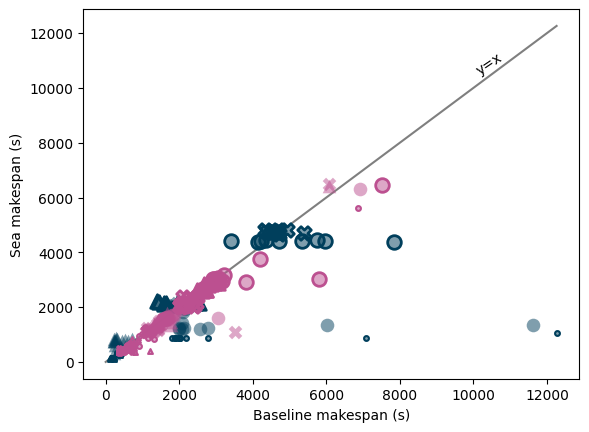

In [3]:
feature_scatter(df_flush, zoom=False, fn='../figures/beluga_withflush_nozoom_updated.pdf')

#### Zoom

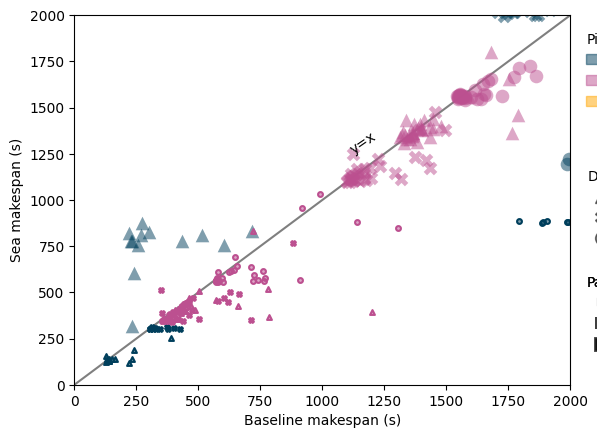

In [4]:
feature_scatter(df_flush, zoom=True, fn='../figures/beluga_withflush_zoom_updated.pdf')

### Beluga results without flushing

In [5]:
df_base = df_noflush[df_noflush["fs"] == "default"].set_index("true_idx")
df_sea = df_noflush[df_noflush["fs"] == "sea"].set_index("true_idx")
df_base["speedup"] = df_base["makespan"].divide(df_sea["makespan"])
df_base["sea_makespan"] = df_sea["makespan"]
df_noflush = df_base

#### No Zoom

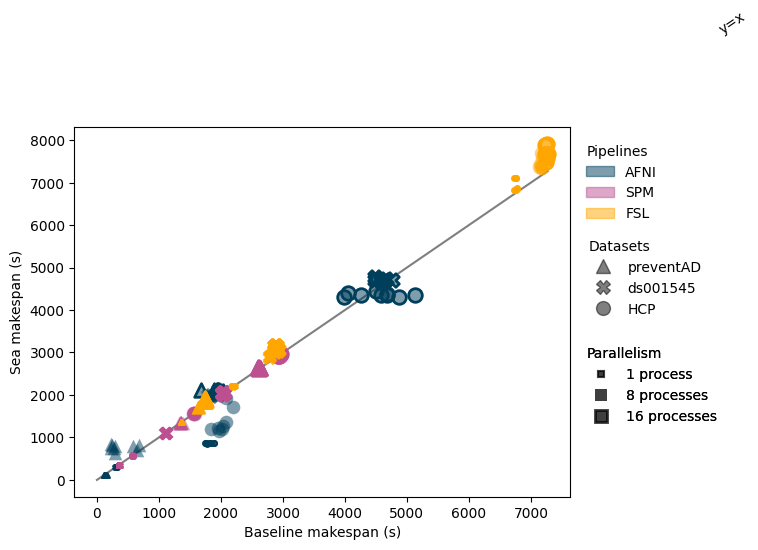

In [6]:
feature_scatter(df_noflush, zoom=False, fn='../figures/beluga_withoutflush_nozoom_updated.pdf')

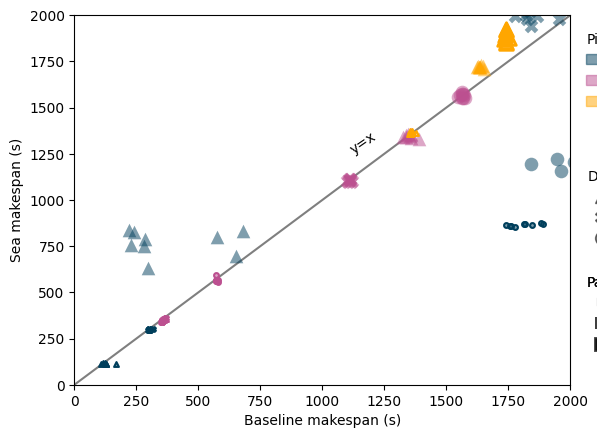

In [7]:
feature_scatter(df_noflush, zoom=True, fn='../figures/beluga_withflush_zoom_updated.pdf')

### Beluga results on tmpfs

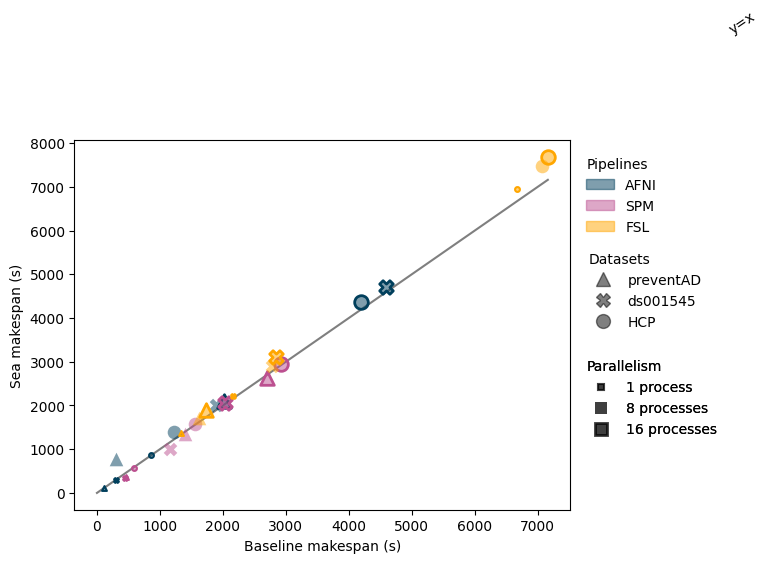

In [8]:
params = ['pipeline', 'dataset', 'n_images']
df_tmpfs = df_tmpfs.sort_values(by=params).reset_index()
df_sea = df_sea[[*params, 'makespan']].rename(columns={"makespan": "sea_makespan"}).sort_values(by=params).groupby(params).mean().reset_index()

df_mem = df_tmpfs.join(df_sea, rsuffix='sea')
feature_scatter(df_mem, zoom=False, fn='../figures/beluga_sea_tmpfs_updated.pdf')


### T-test results

#### Overall - with flush

In [9]:
from scipy.stats import ttest_ind

pipeline = 'spm'
ttest_ind(df_flush.dropna().loc[df_flush['pipeline'] == pipeline]['makespan'],
          df_flush.loc[df_flush['pipeline'] == pipeline].dropna()['sea_makespan'])

TtestResult(statistic=0.7691596923725971, pvalue=0.4420952516860117, df=612.0)

In [10]:
pipeline = 'afni' 
ttest_ind(df_flush.dropna().loc[df_flush['pipeline'] == pipeline]['makespan'],
          df_flush.loc[df_flush['pipeline'] == pipeline].dropna()['sea_makespan'])

TtestResult(statistic=1.6140184312086763, pvalue=0.10796992887585767, df=218.0)

#### Overall - No flush

In [11]:
pipeline = 'fsl'
df = df_noflush
ttest_ind(df.dropna().loc[df['pipeline'] == pipeline]['makespan'],
          df.loc[df['pipeline'] == pipeline].dropna()['sea_makespan'])

TtestResult(statistic=-0.4250808376144147, pvalue=0.6713711072676318, df=154.0)

In [12]:
pipeline = 'spm'
df = df_noflush
ttest_ind(df.dropna().loc[df['pipeline'] == pipeline]['makespan'],
          df.loc[df['pipeline'] == pipeline].dropna()['sea_makespan'])

TtestResult(statistic=-0.0009636314452053151, pvalue=0.9992323338753828, df=160.0)

In [13]:
pipeline = 'afni'
df = df_noflush
ttest_ind(df.dropna().loc[df['pipeline'] == pipeline]['makespan'],
          df.loc[df['pipeline'] == pipeline].dropna()['sea_makespan'])

TtestResult(statistic=0.4123748176859627, pvalue=0.6806457417794036, df=152.0)

#### By dataset and pipeline - with flushing

In [14]:
pipeline = 'spm'
dataset = 'HCP'
df = df_flush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=0.6673345443135779, pvalue=0.5053200934650248, df=202.0)

In [15]:
pipeline = 'spm'
dataset = 'preventAD'
df = df_flush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=0.16790214225478786, pvalue=0.8668282462264619, df=202.0)

In [16]:
pipeline = 'spm'
dataset = 'ds001545'
df = df_flush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=0.5003401242517482, pvalue=0.6173749325696384, df=204.0)

In [17]:
pipeline = 'afni'
dataset = 'HCP'
df = df_flush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=3.2378174543379004, pvalue=0.0019361421287096695, df=62.0)

In [18]:
pipeline = 'afni'
dataset = 'preventAD'
df = df_flush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=-1.0997567066594178, pvalue=0.27490955888266716, df=76.0)

In [19]:
pipeline = 'afni'
dataset = 'ds001545'
df = df_flush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=-0.1810700532275623, pvalue=0.856794605555381, df=76.0)

#### Dataset and Pipeline - without flushing

In [20]:
pipeline = 'fsl'
dataset = 'HCP'
df = df_noflush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=-3.7425842447195268, pvalue=0.0005046443093416435, df=46.0)

In [21]:
pipeline = 'fsl'
dataset = 'preventAD'
df = df_noflush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=-1.4431072184889921, pvalue=0.15498761242872708, df=52.0)

In [22]:
pipeline = 'fsl'
dataset = 'ds001545'
df = df_noflush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=-1.2285587313969522, pvalue=0.22476861159917008, df=52.0)

In [23]:
pipeline = 'spm'
dataset = 'HCP'
df = df_noflush
ttest_ind(df.dropna().loc[(df_flush['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=4.365937243601055, pvalue=3.440237906723716e-05, df=88.0)

In [24]:
pipeline = 'spm'
dataset = 'preventAD'
df = df_noflush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=-0.013537255455241018, pvalue=0.9892509683726354, df=52.0)

In [25]:
pipeline = 'spm'
dataset = 'ds001545'
df = df_noflush
ttest_ind(df.dropna().loc[(df['pipeline'] == pipeline)
                          & (df['dataset'] == dataset)]['makespan'],
          df.loc[(df['pipeline'] == pipeline)
                 & (df['dataset'] == dataset)].dropna()['sea_makespan'])

TtestResult(statistic=0.007088005333192896, pvalue=0.9943717605604963, df=52.0)